# running RBA model in python using PyMC

A notebook to run an RBA on fMRI data.  
OHBM Brainhack 2022 project  

Authors:  
Gang Chen, Christopher Nolan, Kelly Garner, [insert extra names here]

- this code assumes that first-level analysis is complete  
- data is structured in the format: subject | ROI | y | x  
- x = predictor variable (in this example a theory of mind score)  
- y = DV of interest from first level analysis - e.g. mu beta coefficient from region of interest (ROI) 

## load required modules

In [37]:
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr
import bambi as bmb
sns.set_theme(style='darkgrid')

## Next we load the data:

In [2]:
df = pd.read_csv('data.txt', delimiter = '\s')
df.head(5)

/tmp/ipykernel_267727/1638352057.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('data.txt', delimiter = '\s')


,subject,ROI,y,x
0,HMN001,RPCC,0.3457,17.76
1,HMN002,RPCC,0.5166,17.05
2,HMN003,RPCC,0.0919,15.81
3,HMN004,RPCC,0.3635,15.19
4,HMN005,RPCC,0.7323,17.31


Next we define the model:

In [3]:
model = bmb.Model("y ~ x + (1|subject) + (x|ROI)", data=df)
fitted = model.fit(draws=1000, chains=16, method='nuts_numpyro')

/home/cnolan/miniconda3/envs/pyrba/lib/python3.10/site-packages/aesara/link/jax/dispatch.py:87: UserWarning: JAX omnistaging couldn't be disabled: Disabling of omnistaging is no longer supported in JAX version 0.2.12 and higher: see https://github.com/google/jax/blob/main/design_notes/omnistaging.md.
  warnings.warn(f"JAX omnistaging couldn't be disabled: {e}")
/home/cnolan/miniconda3/envs/pyrba/lib/python3.10/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


Compiling...
Compilation time =  0:00:24.730814
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:02:11.517522
Transforming variables...
Transformation time =  0:00:00.751043


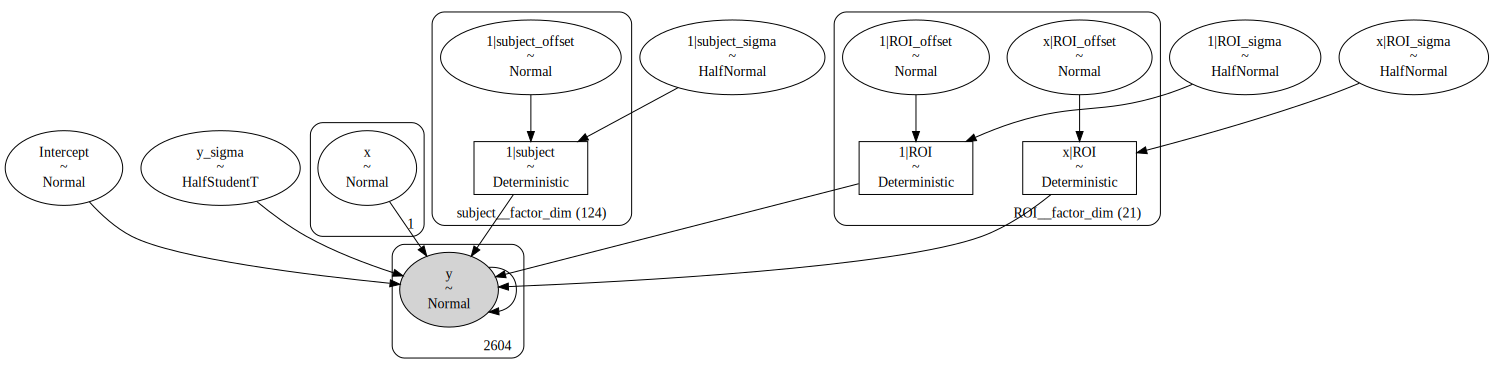

In [5]:
model.graph()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.052,0.065,-0.064,0.180,0.001,0.001,3962.0,6949.0,1.00
x,0.007,0.004,-0.001,0.015,0.000,0.000,3818.0,6406.0,1.00
1|subject_sigma,0.077,0.006,0.066,0.088,0.000,0.000,4392.0,7767.0,1.00
1|ROI_sigma,0.074,0.034,0.000,0.127,0.001,0.000,2451.0,3415.0,1.01
x|ROI_sigma,0.009,0.002,0.005,0.012,0.000,0.000,4722.0,7043.0,1.00
...,...,...,...,...,...,...,...,...,...
x|ROI[RTPJp],0.021,0.006,0.010,0.033,0.000,0.000,2957.0,5600.0,1.01
x|ROI[RvBG],-0.003,0.004,-0.011,0.004,0.000,0.000,6695.0,3950.0,1.00
x|ROI[SGC],-0.004,0.004,-0.010,0.004,0.000,0.000,6098.0,8791.0,1.00
x|ROI[dmMPFC],0.002,0.004,-0.005,0.009,0.000,0.000,5718.0,4711.0,1.00


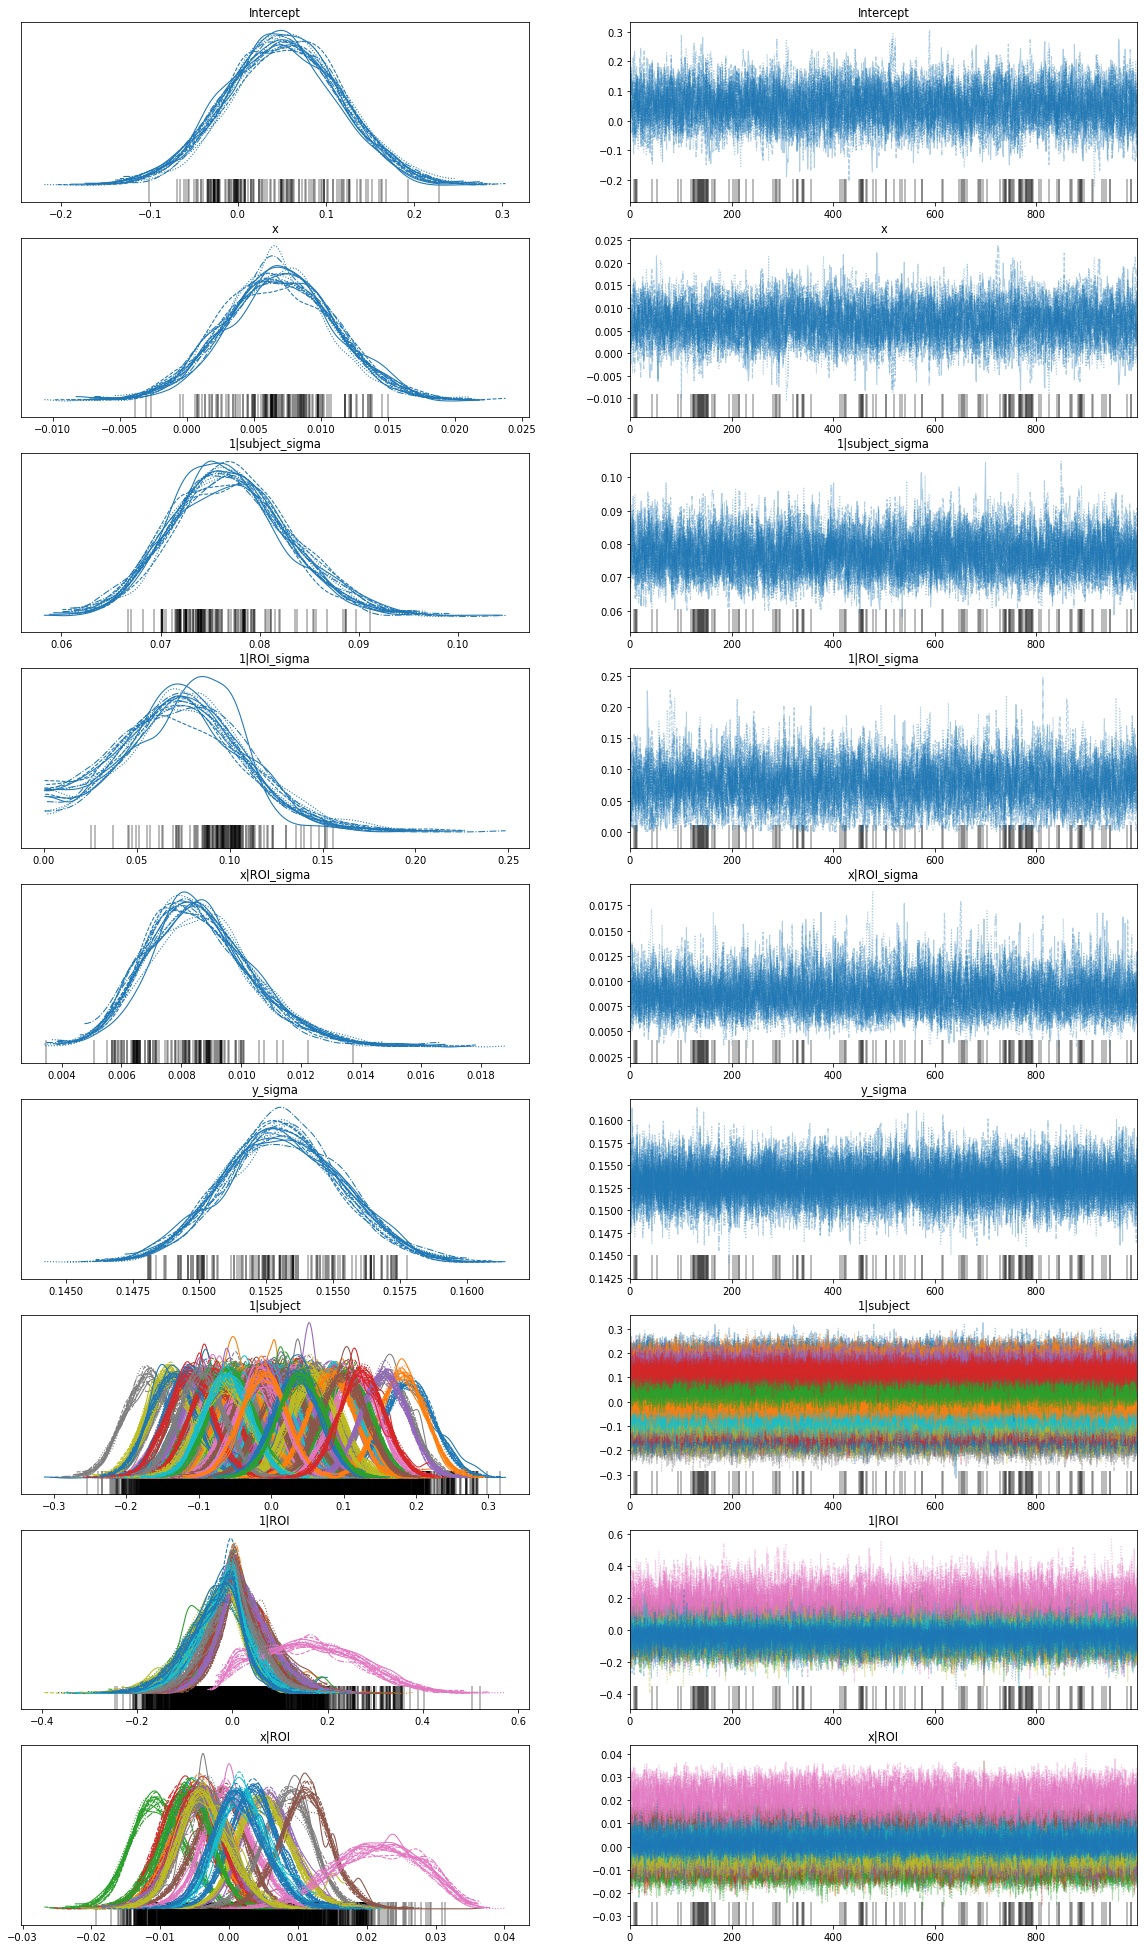

In [7]:
az.plot_trace(fitted, figsize=(20, 35))
az.summary(fitted)

In [48]:
rois = fitted['posterior']['x|ROI'].stack(y=['draw', 'chain']).to_pandas().transpose()
rois.columns.name = 'ROI'
rois = rois.stack()
rois.name = 'value'
rois

draw  chain  ROI       
0     0      ACC          -0.004010
             LAmy/Hippo   -0.001079
             LCing        -0.011201
             LIFG         -0.005251
             LIPL          0.006994
                             ...   
999   15     RTPJp         0.013288
             RvBG         -0.001995
             SGC          -0.004210
             dmMPFC        0.004088
             vmPFC         0.000488
Name: value, Length: 336000, dtype: float64

In [49]:
roi_means = rois.groupby(['ROI']).mean().sort_values(ascending=False)

In [51]:
roi_df = rois.to_frame()
roi_df['roi_mean'] = roi_df.groupby(['ROI']).transform('mean')
roi_df

value  roi_mean
draw chain ROI                           
0    0     ACC        -0.004010 -0.005172
           LAmy/Hippo -0.001079 -0.005152
           LCing      -0.011201 -0.010226
           LIFG       -0.005251 -0.006598
           LIPL        0.006994  0.005738
...                         ...       ...
999  15    RTPJp       0.013288  0.021447
           RvBG       -0.001995 -0.003455
           SGC        -0.004210 -0.003631
           dmMPFC      0.004088  0.002003
           vmPFC       0.000488  0.001407

[336000 rows x 2 columns]